In [1]:
import numpy as np
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [2]:
# 将图像数据展开为向量形式
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [3]:
def softmax(x):
    x = x.astype(np.float)
    xmax = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - xmax)
    smax = np.sum(e_x, axis=1, keepdims=True)
    return e_x / smax


def CrossEntropy(predict, target):
    N = predict.shape[0]
    entropy = -np.log(predict[np.arange(N), target])
    return entropy

In [34]:
from tqdm import tqdm
import matplotlib.pyplot as plt


class TwoLayerModel:
    def __init__(self, hidden_size, input_size=784, output_size=10, std=1e-4):
        self.params = {'W1': std * np.random.randn(input_size, hidden_size), 'b1': np.zeros(hidden_size),
                       'W2': std * np.random.randn(hidden_size, output_size), 'b2': np.zeros(output_size)}
        self.patience = 5

    def forward(self, X):
        O = {'X': X}
        Y_1 = np.dot(X, self.params['W1']) + self.params['b1']
        o_1 = 1 / (1 + np.exp(-Y_1))
        Y_2 = np.dot(o_1, self.params['W2']) + self.params['b2']
        o_2 = softmax(Y_2)
        O['Y_1'], O['o_1'], O['Y_2'], O['o_2'] = Y_1, o_1, Y_2, o_2
        return O

    def loss_grad(self, X, y, reg):
        O = self.forward(X)
        Y_1, o_1, Y_2, o_2 = O['Y_1'], O['o_1'], O['Y_2'], O['o_2']
        N = X.shape[0]
        loss = np.sum(CrossEntropy(o_2, y)) / N
        dY_2 = o_2.copy()
        dY_2[np.arange(N), y] -= 1
        dY_2 /= N

        # backward
        dW2 = np.dot(o_1.T, dY_2)
        db2 = np.sum(dY_2, axis=0)
        do_1 = np.dot(dY_2, self.params['W2'].T)
        dY_1 = np.multiply(do_1, 1 - do_1)
        dW1 = np.dot(X.T, dY_1)
        db1 = np.sum(dY_1, axis=0)
        dW2 += reg * self.params['W2']
        dW1 += reg * self.params['W1']
        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
        return loss, grads

    def train(self, X, y, reg, epochs=50, lr=0.01, lr_decay=1, batch_size=32):
        N, D = X.shape
        num_iter = N // batch_size
        avgl = []
        train_avgacc, pred_avgacc = [], []
        # patience = 0
        # best_val = 0
        for epoch in range(epochs):
            L = 0
            for i in tqdm(range(num_iter)):
                batch_indices = np.random.choice(N, batch_size, replace=True)
                X_batch = X[batch_indices]
                Y_batch = y[batch_indices]
                loss, grads = self.loss_grad(X_batch, Y_batch, reg)
                L += loss
                # 更新参数
                self.params['W1'] -= lr * grads['W1']
                self.params['b1'] -= lr * grads['b1']
                self.params['W2'] -= lr * grads['W2']
                self.params['b2'] -= lr * grads['b2']
                # if not i % 5000:
            if not epoch and epoch % 20 == 0:
                lr *= lr_decay
            # lr_decay *= 0.95
            train_acc = (self.predict(X_train) == y_train).mean()
            pred_acc = (self.predict(X_test) == y_test).mean()
            # patience += 1
            # if train_acc > best_val:
            #     best_val = pred_acc
            #     patience = 0
            # elif patience >= self.patience:
            #     break
            L /= num_iter
            avgl.append(L)
            train_avgacc.append(train_acc)
            pred_avgacc.append(pred_acc)
            print(f"epoch {epoch} loss: {L}, train_acc {train_acc},pred_acc {pred_acc}")
        return avgl, train_avgacc, pred_avgacc

    def predict(self, X):
        o_2 = self.forward(X)['o_2']
        y_pred = np.argmax(o_2, axis=1)
        return y_pred

    def save(self, path):
        with open(path, 'w') as f:
            f.write(f'params: {self.params}')
            f.write("activate function: sigmoid")

  0%|          | 0/1875 [00:00<?, ?it/s]C:\Users\99480\AppData\Local\Temp\ipykernel_11376\3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
C:\Users\99480\AppData\Local\Temp\ipykernel_11376\1681085911.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
100%|██████████| 1875/1875 [00:03<00:00, 549.04it/s]


epoch 0 loss: 1.657721481128377, train_acc 0.5433666666666667,pred_acc 0.5442


100%|██████████| 1875/1875 [00:04<00:00, 454.36it/s]


epoch 1 loss: 1.3569000150229702, train_acc 0.5986666666666667,pred_acc 0.5927


100%|██████████| 1875/1875 [00:03<00:00, 525.62it/s]


epoch 2 loss: 1.1774283363952531, train_acc 0.7076666666666667,pred_acc 0.7112


100%|██████████| 1875/1875 [00:03<00:00, 488.17it/s]


epoch 3 loss: 0.9980727088722079, train_acc 0.7307833333333333,pred_acc 0.7329


100%|██████████| 1875/1875 [00:03<00:00, 487.73it/s]


epoch 4 loss: 0.8854342865440331, train_acc 0.7848166666666667,pred_acc 0.7857


100%|██████████| 1875/1875 [00:03<00:00, 474.75it/s]


epoch 5 loss: 0.8015291209126632, train_acc 0.8192333333333334,pred_acc 0.8247


100%|██████████| 1875/1875 [00:04<00:00, 464.08it/s]


epoch 6 loss: 0.715080527389075, train_acc 0.8229333333333333,pred_acc 0.8281


100%|██████████| 1875/1875 [00:04<00:00, 425.97it/s]


epoch 7 loss: 0.6654056087738057, train_acc 0.82785,pred_acc 0.8327


100%|██████████| 1875/1875 [00:04<00:00, 465.13it/s]


epoch 8 loss: 0.6474744558911726, train_acc 0.8376833333333333,pred_acc 0.8453


100%|██████████| 1875/1875 [00:04<00:00, 452.23it/s]


epoch 9 loss: 0.619690217142033, train_acc 0.8402,pred_acc 0.8457


100%|██████████| 1875/1875 [00:04<00:00, 455.22it/s]


epoch 10 loss: 0.5950669990968297, train_acc 0.8430833333333333,pred_acc 0.8491


100%|██████████| 1875/1875 [00:03<00:00, 503.94it/s]


epoch 11 loss: 0.57382577046261, train_acc 0.8474166666666667,pred_acc 0.8544


100%|██████████| 1875/1875 [00:03<00:00, 494.30it/s]


epoch 12 loss: 0.5618885971187076, train_acc 0.8490666666666666,pred_acc 0.8557


100%|██████████| 1875/1875 [00:04<00:00, 449.46it/s]


epoch 13 loss: 0.5432089016242421, train_acc 0.8546,pred_acc 0.8652


100%|██████████| 1875/1875 [00:03<00:00, 491.75it/s]


epoch 14 loss: 0.5285987256478267, train_acc 0.8564,pred_acc 0.8654


100%|██████████| 1875/1875 [00:03<00:00, 473.85it/s]


epoch 15 loss: 0.5126155534863931, train_acc 0.8588333333333333,pred_acc 0.8668


100%|██████████| 1875/1875 [00:03<00:00, 486.19it/s]


epoch 16 loss: 0.48999710249495954, train_acc 0.8642833333333333,pred_acc 0.8722


100%|██████████| 1875/1875 [00:04<00:00, 450.85it/s]


epoch 17 loss: 0.4750550546898193, train_acc 0.87225,pred_acc 0.8794


100%|██████████| 1875/1875 [00:04<00:00, 382.65it/s]


epoch 18 loss: 0.4614769529540436, train_acc 0.8757666666666667,pred_acc 0.8829


100%|██████████| 1875/1875 [00:04<00:00, 380.14it/s]


epoch 19 loss: 0.451379575267232, train_acc 0.8778666666666667,pred_acc 0.883


100%|██████████| 1875/1875 [00:04<00:00, 394.10it/s]


epoch 20 loss: 0.44237574372943295, train_acc 0.8768333333333334,pred_acc 0.8827


100%|██████████| 1875/1875 [00:04<00:00, 384.46it/s]


epoch 21 loss: 0.4383828485323592, train_acc 0.8774,pred_acc 0.8829


100%|██████████| 1875/1875 [00:04<00:00, 415.02it/s]


epoch 22 loss: 0.4424906204801917, train_acc 0.8761,pred_acc 0.881


100%|██████████| 1875/1875 [00:04<00:00, 383.37it/s]


epoch 23 loss: 0.4335806488846994, train_acc 0.8753666666666666,pred_acc 0.8791


100%|██████████| 1875/1875 [00:04<00:00, 385.96it/s]


epoch 24 loss: 0.4382570791765493, train_acc 0.8745,pred_acc 0.8786


100%|██████████| 1875/1875 [00:04<00:00, 388.02it/s]


epoch 25 loss: 0.43081588675283033, train_acc 0.8748166666666667,pred_acc 0.8784


100%|██████████| 1875/1875 [00:04<00:00, 382.57it/s]


epoch 26 loss: 0.43500924150169523, train_acc 0.8720666666666667,pred_acc 0.8776


100%|██████████| 1875/1875 [00:04<00:00, 389.78it/s]


epoch 27 loss: 0.4207028181119047, train_acc 0.8704666666666667,pred_acc 0.8773


100%|██████████| 1875/1875 [00:04<00:00, 385.91it/s]


epoch 28 loss: 0.423273558988159, train_acc 0.8705333333333334,pred_acc 0.8777


100%|██████████| 1875/1875 [00:04<00:00, 390.40it/s]


epoch 29 loss: 0.4231398191897351, train_acc 0.87,pred_acc 0.8737


100%|██████████| 1875/1875 [00:04<00:00, 377.63it/s]


epoch 30 loss: 0.42410683986012715, train_acc 0.8712166666666666,pred_acc 0.8745


100%|██████████| 1875/1875 [00:04<00:00, 382.05it/s]


epoch 31 loss: 0.4243230389489588, train_acc 0.8719666666666667,pred_acc 0.8743


100%|██████████| 1875/1875 [00:04<00:00, 412.06it/s]


epoch 32 loss: 0.41679554660153534, train_acc 0.8712166666666666,pred_acc 0.8743


100%|██████████| 1875/1875 [00:05<00:00, 372.56it/s]


epoch 33 loss: 0.40981153821267835, train_acc 0.8746333333333334,pred_acc 0.8788


100%|██████████| 1875/1875 [00:04<00:00, 379.66it/s]


epoch 34 loss: 0.41140657493653665, train_acc 0.8752833333333333,pred_acc 0.8798


100%|██████████| 1875/1875 [00:04<00:00, 389.45it/s]


epoch 35 loss: 0.40514940755247336, train_acc 0.8757833333333334,pred_acc 0.8816


100%|██████████| 1875/1875 [00:04<00:00, 379.83it/s]


epoch 36 loss: 0.41185820349999774, train_acc 0.8754666666666666,pred_acc 0.8826


100%|██████████| 1875/1875 [00:04<00:00, 398.58it/s]


epoch 37 loss: 0.4079039368226404, train_acc 0.8752666666666666,pred_acc 0.8828


100%|██████████| 1875/1875 [00:04<00:00, 380.14it/s]


epoch 38 loss: 0.4064493250618605, train_acc 0.8757666666666667,pred_acc 0.8834


100%|██████████| 1875/1875 [00:04<00:00, 393.83it/s]


epoch 39 loss: 0.4070537530126239, train_acc 0.8769333333333333,pred_acc 0.884


100%|██████████| 1875/1875 [00:04<00:00, 387.45it/s]


epoch 40 loss: 0.40314567515956107, train_acc 0.8778833333333333,pred_acc 0.8849


100%|██████████| 1875/1875 [00:04<00:00, 383.09it/s]


epoch 41 loss: 0.40181473728494455, train_acc 0.8784833333333333,pred_acc 0.8844


100%|██████████| 1875/1875 [00:04<00:00, 402.72it/s]


epoch 42 loss: 0.40902642662432553, train_acc 0.8802333333333333,pred_acc 0.8856


100%|██████████| 1875/1875 [00:04<00:00, 397.22it/s]


epoch 43 loss: 0.40620291985113266, train_acc 0.8790666666666667,pred_acc 0.8825


100%|██████████| 1875/1875 [00:04<00:00, 383.80it/s]


epoch 44 loss: 0.403003415366721, train_acc 0.8783333333333333,pred_acc 0.8825


100%|██████████| 1875/1875 [00:04<00:00, 390.67it/s]


epoch 45 loss: 0.4010603005585295, train_acc 0.8818833333333334,pred_acc 0.8851


100%|██████████| 1875/1875 [00:04<00:00, 394.05it/s]


epoch 46 loss: 0.4122160043092009, train_acc 0.8793,pred_acc 0.8829


100%|██████████| 1875/1875 [00:04<00:00, 451.55it/s]


epoch 47 loss: 0.39955009811538583, train_acc 0.8808833333333334,pred_acc 0.885


100%|██████████| 1875/1875 [00:04<00:00, 381.95it/s]


epoch 48 loss: 0.3991485398443144, train_acc 0.8811666666666667,pred_acc 0.8845


100%|██████████| 1875/1875 [00:03<00:00, 552.33it/s]


epoch 49 loss: 0.3957501906117794, train_acc 0.8822666666666666,pred_acc 0.8853


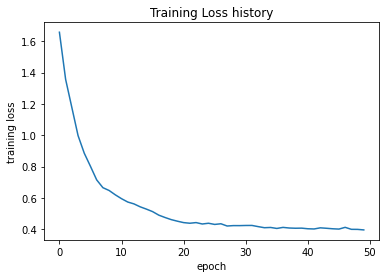

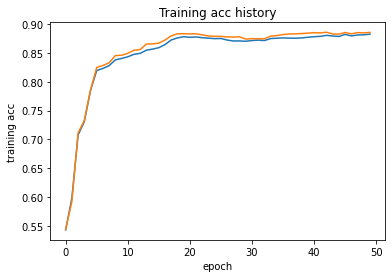

In [35]:
model = TwoLayerModel(128)
L, train_acc, pred_acc = model.train(X_train, y_train, reg=1e-6)
plt.plot(L)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()
plt.plot(train_acc)
plt.plot(pred_acc)
plt.xlabel('epoch')
plt.ylabel('training acc')
plt.title('Training acc history')
plt.show()

In [36]:
predict = model.predict(X_test)
test_acc = (predict == y_test).mean()
print(f"acc:{test_acc}")

acc:0.8853


C:\Users\99480\AppData\Local\Temp\ipykernel_11376\1681085911.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
C:\Users\99480\AppData\Local\Temp\ipykernel_11376\3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)


In [37]:
model.save('model.txt')

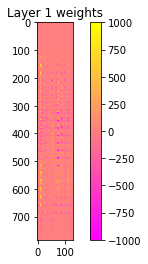

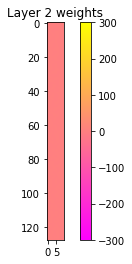

In [38]:
plt.figure(1)
plt.imshow(model.params['W1'], cmap='spring', vmin=-1000, vmax=1000)
plt.title('Layer 1 weights')
plt.colorbar()
plt.show()
plt.figure(1)
plt.imshow(model.params['W2'], cmap='spring', vmin=-300, vmax=300)
plt.title('Layer 2 weights')
plt.colorbar()
plt.show()